# Cel projektu
Celem projektu jest opracowanie modelu predykcyjnego Long-Short Term Memory (LSTM), który oszacuje za pomocą regresji liniowej wartość kursu BTCUSD na podstawie wprowadzonych danych wejściowych z innych instrumentów.

Następnie, model zostanie porównany z predykcją średniej kroczącej, a także zmodyfikowany do działania wyłącznie na podstawie kursu BTCUSD. Metryki wykorzystane do oceny jakości to Mean Squared Error (MSE) oraz Mean Absolute Error (MAE).

Ostatnim etapem projektu jest wprowadzenie elementu generalizacji za pomocą innych danych dotyczących. Nowymi danymi wejściowymi i wyjściowymi będzie kurs NASDAQ.

# 1. Wczytanie danych

In [1]:
import pandas as pd
from siml_data import Featureset

In [2]:
feature_loader = Featureset()

In [3]:
df = feature_loader.get()

## Sprawdzenie typów i wartości nienumerycznych

In [4]:
df.isna().sum().sum()

0

In [5]:
df.dtypes

GCM24Open        float64
GCM24High        float64
GCM24Low         float64
GCM24Close       float64
IXICOpen         float64
IXICHigh         float64
IXICLow          float64
IXICClose        float64
HKDOpen          float64
HKDHigh          float64
HKDLow           float64
HKDClose         float64
GXCOpen          float64
GXCHigh          float64
GXCLow           float64
GXCClose         float64
CNYOpen          float64
CNYHigh          float64
CNYLow           float64
CNYClose         float64
GSPCOpen         float64
GSPCHigh         float64
GSPCLow          float64
GSPCClose        float64
CLK24Open        float64
CLK24High        float64
CLK24Low         float64
CLK24Close       float64
MCHIOpen         float64
MCHIHigh         float64
MCHILow          float64
MCHIClose        float64
0386Open         float64
0386High         float64
0386Low          float64
0386Close        float64
BLKOpen          float64
BLKHigh          float64
BLKLow           float64
BLKClose         float64


## Filtrowanie po cenie zamknięcia

In [6]:
[x for x in df.columns if 'btc' in x.lower()]

['btcusd_dOpen', 'btcusd_dHigh', 'btcusd_dLow', 'btcusd_dClose']

In [7]:
df = df.drop(columns=[c for c in df.columns if 'Close' not in c])

## Korelacja

<Axes: >

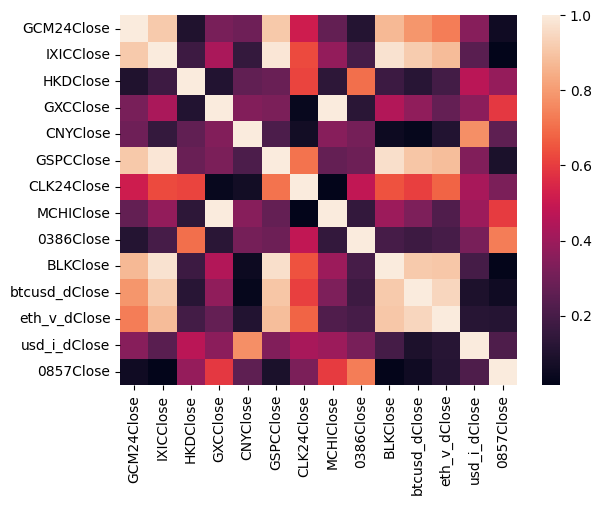

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

corr = df.corr().abs()
sns.heatmap(corr)

In [9]:
corr['btcusd_dClose'].sort_values(ascending=False).head(10)

btcusd_dClose    1.000000
eth_v_dClose     0.945606
IXICClose        0.916503
BLKClose         0.912576
GSPCClose        0.902721
GCM24Close       0.786737
CLK24Close       0.605982
GXCClose         0.372193
MCHIClose        0.327378
0386Close        0.173504
Name: btcusd_dClose, dtype: float64

## Selekcja danych wejściowych

In [10]:
import numpy as np
from sklearn.linear_model import LinearRegression

In [11]:
regressor = LinearRegression()
regressor.fit(df.drop(columns=['btcusd_dClose']).values, df['btcusd_dClose'].values)

LinearRegression()

In [12]:
feature_names = df.drop(columns=['btcusd_dClose']).columns
feature_coef = np.log(np.abs(regressor.coef_)) + 1
feature_relevance = pd.DataFrame(
    {k:[v, corr.loc[k, 'btcusd_dClose']] for k,v in zip(feature_names, feature_coef)}).T.rename(
    columns={0:'coef', 1:'corr'})

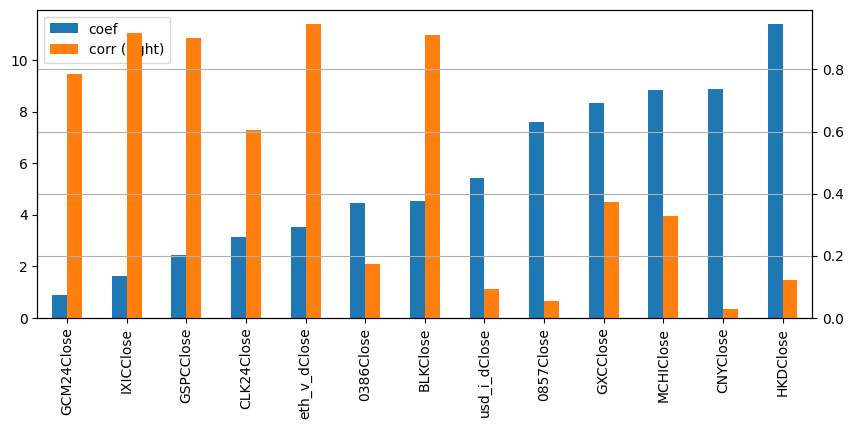

In [14]:
feature_relevance.sort_values(by='coef').plot(kind='bar', secondary_y='corr', figsize=(10,4))
plt.grid()

In [14]:
feature_relevance.describe()

,coef,corr
count,13.000000,13.000000
mean,5.464663,0.479818
std,3.252491,0.373876
min,0.871712,0.028453
25%,3.137622,0.119805
50%,4.512128,0.372193
75%,8.332120,0.902721
max,11.386364,0.945606


In [15]:
threshold = {'coef':3.2, 'corr':0.9}
best_features = (feature_relevance['coef'] > threshold['coef']) | (feature_relevance['corr'] > threshold['corr'])
selected_features = best_features[best_features.values].index.tolist()
selected_features

['IXICClose',
 'HKDClose',
 'GXCClose',
 'CNYClose',
 'GSPCClose',
 'MCHIClose',
 '0386Close',
 'BLKClose',
 'eth_v_dClose',
 'usd_i_dClose',
 '0857Close']

## Utworzenie zbiorów uczących

In [16]:
from siml_pipeline import Pipeline

In [112]:
p = Pipeline()
X_train, X_test, Y_train, Y_test = p.process(df[selected_features + ['btcusd_dClose']], 'btcusd_dClose')

In [113]:
n_of_features = X_train.shape[-1]
X_train.shape, X_test.shape, Y_train.shape, Y_test.shape

((1240, 10, 11), (407, 10, 11), (1240, 1), (407, 1))

# 2. Trenowanie modelu LSTM

In [98]:
from siml_model import build_model

In [99]:
model = build_model(p.num_days, n_of_features)

Liczba trenowalnych parametrów powinna mieć podobny rząd wartości co rozmiar zbioru uczącego.

In [100]:
model.summary()

Model: "sequential_33"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_99 (LSTM)               (None, 10, 24)            3456      
_________________________________________________________________
dropout_99 (Dropout)         (None, 10, 24)            0         
_________________________________________________________________
lstm_100 (LSTM)              (None, 10, 12)            1776      
_________________________________________________________________
dropout_100 (Dropout)        (None, 10, 12)            0         
_________________________________________________________________
lstm_101 (LSTM)              (None, 10, 6)             456       
_________________________________________________________________
dropout_101 (Dropout)        (None, 10, 6)             0         
_________________________________________________________________
flatten_33 (Flatten)         (None, 60)              

In [101]:
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mae'])

In [102]:
epochs = 10
batch = 32

history = model.fit(X_train,
                    Y_train,
                    validation_data=(X_test, Y_test),
                    epochs=epochs,
                    batch_size=batch)

Epoch 1/10
39/39 [==============================] - 6s 62ms/step - loss: 0.7299 - mae: 0.6509 - val_loss: 1.6372 - val_mae: 1.0544
Epoch 2/10
39/39 [==============================] - 2s 43ms/step - loss: 0.3807 - mae: 0.4896 - val_loss: 1.5198 - val_mae: 1.0352
Epoch 3/10
39/39 [==============================] - 2s 41ms/step - loss: 0.2784 - mae: 0.4027 - val_loss: 1.7448 - val_mae: 1.1566
Epoch 4/10
39/39 [==============================] - 2s 41ms/step - loss: 0.1693 - mae: 0.2652 - val_loss: 1.4894 - val_mae: 1.0594
Epoch 5/10
39/39 [==============================] - 1s 38ms/step - loss: 0.1319 - mae: 0.2222 - val_loss: 1.3784 - val_mae: 1.0057
Epoch 6/10
39/39 [==============================] - 1s 37ms/step - loss: 0.1148 - mae: 0.2028 - val_loss: 1.2816 - val_mae: 0.9588
Epoch 7/10
39/39 [==============================] - 2s 40ms/step - loss: 0.1176 - mae: 0.1982 - val_loss: 1.1591 - val_mae: 0.9005
Epoch 8/10
39/39 [==============================] - 2s 40ms/step - loss: 0.1065 - m

## Wyniki trenowania
Historia wartości MSE (loss) oraz dodatkowej metryki MAE na zbiorze trenującym i testowym (val).

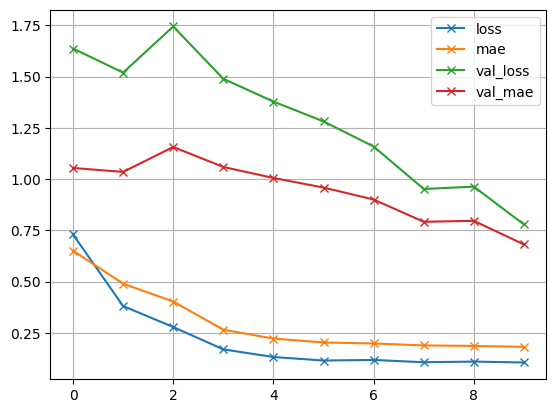

In [103]:
for k,v in history.history.items():
    plt.plot(v, 'x-', label=k)
plt.legend()
plt.grid()

# 3. Ewaluacja modelu

In [104]:
MA = df.rolling(window=10).mean().rename(columns=lambda n: n.replace('Close', 'MA'))

In [120]:
btc_hat = p.restore(model.predict(X_test)).ravel()
btc_hat = pd.Series(btc_hat, name='prediction', index=df.index[-len(btc_hat):])

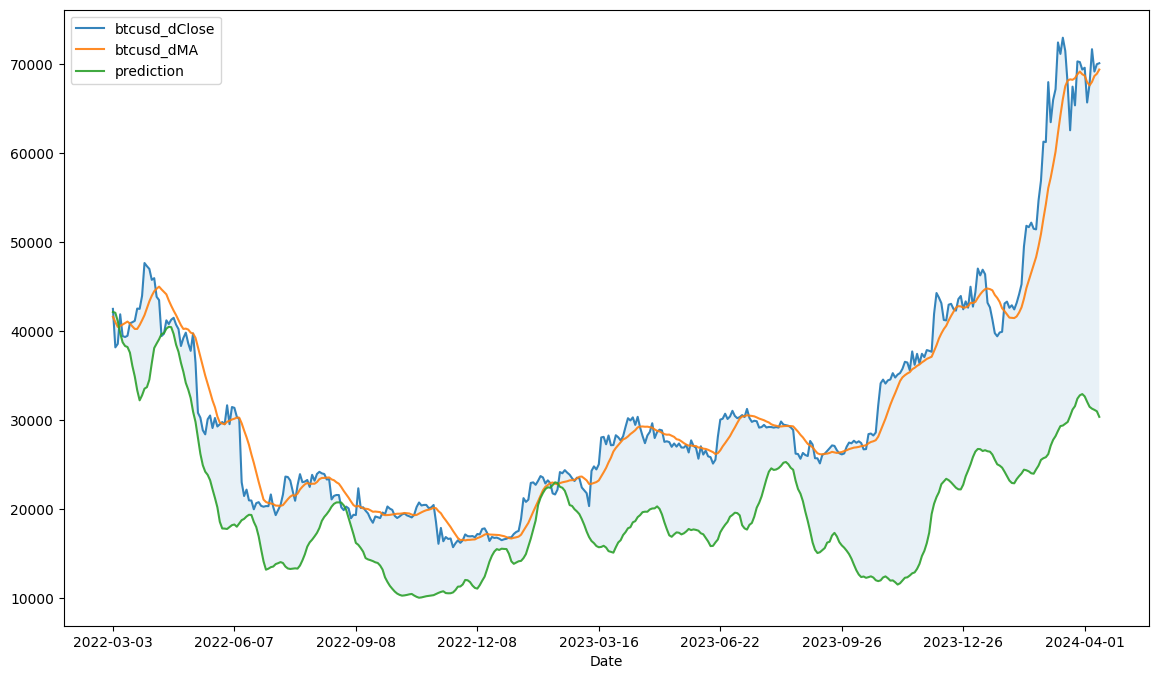

In [121]:
btc = pd.concat([df['btcusd_dClose'], MA['btcusd_dMA'], btc_hat], axis=1).dropna()
btc.plot(figsize=(14,8), style='-', alpha=0.9)
plt.fill_between(btc.index, btc['prediction'], btc['btcusd_dClose'], alpha=0.1)

<Axes: >

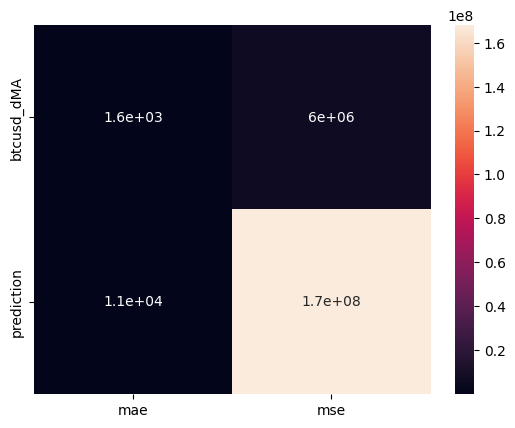

In [107]:
err = btc - pd.concat([btc['btcusd_dClose']] * 3, axis=1).values
err.drop('btcusd_dClose', axis=1, inplace=True)
mae = err.abs().mean()
mse = (err ** 2).mean()
sns.heatmap(pd.DataFrame({'mae':mae, 'mse':mse}), annot=True)

## Predykcja na podstawie samego kursu

In [108]:
from siml_pipeline import SingleFeaturePipeline
ONE_FEATURE = 1

In [109]:
sp = SingleFeaturePipeline()
X_train, X_test, Y_train, Y_test = sp.process(df['btcusd_dClose'])

In [32]:
model = build_model(sp.num_days, ONE_FEATURE, output_size=sp.look_ahead)

In [33]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 10, 24)            2496      
_________________________________________________________________
dropout_3 (Dropout)          (None, 10, 24)            0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 10, 12)            1776      
_________________________________________________________________
dropout_4 (Dropout)          (None, 10, 12)            0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 10, 6)             456       
_________________________________________________________________
dropout_5 (Dropout)          (None, 10, 6)             0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 60)               

In [34]:
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mae'])

In [35]:
from tensorflow.keras.callbacks import EarlyStopping

epochs = 10
batch = 32

history = model.fit(X_train,
                    Y_train,
                    validation_data=(X_test, Y_test),
                    epochs=epochs,
                    batch_size=batch,
                    callbacks=[EarlyStopping(patience=2)])

Epoch 1/10
40/40 [==============================] - 4s 34ms/step - loss: 0.9280 - mae: 0.8120 - val_loss: 0.9068 - val_mae: 0.7192
Epoch 2/10
40/40 [==============================] - 1s 22ms/step - loss: 0.4632 - mae: 0.4859 - val_loss: 0.3818 - val_mae: 0.4260
Epoch 3/10
40/40 [==============================] - 1s 24ms/step - loss: 0.2130 - mae: 0.2965 - val_loss: 0.1665 - val_mae: 0.2692
Epoch 4/10
40/40 [==============================] - 1s 25ms/step - loss: 0.1206 - mae: 0.2278 - val_loss: 0.1129 - val_mae: 0.2477
Epoch 5/10
40/40 [==============================] - 1s 23ms/step - loss: 0.0893 - mae: 0.2004 - val_loss: 0.1149 - val_mae: 0.2538
Epoch 6/10
40/40 [==============================] - 1s 26ms/step - loss: 0.0830 - mae: 0.1901 - val_loss: 0.1168 - val_mae: 0.2685


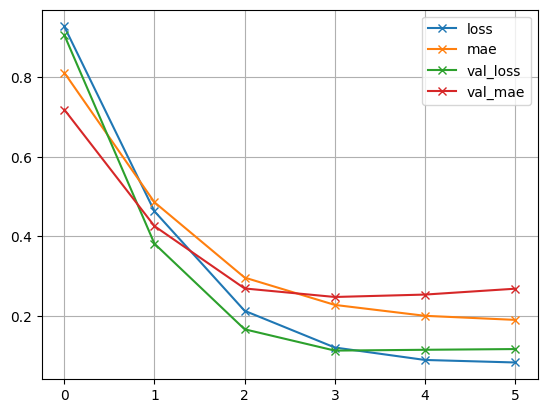

In [36]:
for k,v in history.history.items():
    plt.plot(v, 'x-', label=k)
plt.legend()
plt.grid()

## Grid Search
Optymalizacja parametrów batch_size, num_days, look_ahead.

In [37]:
batch_size_domain = [2, 4, 8, 16, 32, 64, 128, 256]
num_days_domain = [10, 12, 14, 16, 18, 20]
look_ahead_domain = [2, 4, 6, 8, 10]

In [38]:
domain = []
for bs in batch_size_domain:
    for nd in num_days_domain:
        for la in look_ahead_domain:
            domain.append({'batch_size': bs, 'num_days': nd, 'look_ahead': la})
domain = np.array(domain)
len(domain)

240

In [39]:
FRACTION = 0.1
sample_size = int(len(domain) * FRACTION)
domain_sample = np.hstack([np.zeros(len(domain) - sample_size), np.ones(sample_size)])
np.random.shuffle(domain_sample)
domain = domain[domain_sample.astype(bool)]
len(domain)

24

In [40]:
def evaluate_model(num_days=10, look_ahead=8, batch_size=32, epochs=10):
    sp = SingleFeaturePipeline(num_days=num_days, look_ahead=look_ahead)
    X_train, X_test, Y_train, Y_test = sp.process(df['btcusd_dClose'])
    model = build_model(sp.num_days, ONE_FEATURE, output_size=sp.look_ahead)
    model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mae'])
    history = model.fit(X_train,
                        Y_train,
                        validation_data=(X_test, Y_test),
                        epochs=epochs,
                        batch_size=batch_size,
                        callbacks=[EarlyStopping(patience=2)],
                        verbose=0)
    return history.history['val_loss'][-1]

In [41]:
grid_search = []
for params in domain:
    grid_search.append({'params':params, 'result':evaluate_model(**params)})
grid_search = pd.DataFrame(grid_search)

In [44]:
grid_search.sort_values(by='result').head(5)

,params,result
11,"{'batch_size': 16, 'num_days': 16, 'look_ahead...",0.016077
1,"{'batch_size': 2, 'num_days': 16, 'look_ahead'...",0.020947
4,"{'batch_size': 2, 'num_days': 20, 'look_ahead'...",0.024540
7,"{'batch_size': 8, 'num_days': 12, 'look_ahead'...",0.024609
10,"{'batch_size': 16, 'num_days': 12, 'look_ahead...",0.029173


In [46]:
best_params = grid_search.sort_values(by='result').iloc[0,0]
best_params

{'batch_size': 16, 'num_days': 16, 'look_ahead': 4}

Epoch 1/10
79/79 [==============================] - 9s 58ms/step - loss: 0.4940 - mae: 0.5063 - val_loss: 0.0584 - val_mae: 0.1833
Epoch 2/10
79/79 [==============================] - 4s 47ms/step - loss: 0.0821 - mae: 0.1797 - val_loss: 0.0494 - val_mae: 0.1912
Epoch 3/10
79/79 [==============================] - 4s 48ms/step - loss: 0.0549 - mae: 0.1467 - val_loss: 0.0716 - val_mae: 0.2360
Epoch 4/10
79/79 [==============================] - 4s 50ms/step - loss: 0.0440 - mae: 0.1302 - val_loss: 0.0300 - val_mae: 0.1356
Epoch 5/10
79/79 [==============================] - 4s 46ms/step - loss: 0.0352 - mae: 0.1210 - val_loss: 0.0256 - val_mae: 0.1195
Epoch 6/10
79/79 [==============================] - 3s 44ms/step - loss: 0.0369 - mae: 0.1188 - val_loss: 0.0273 - val_mae: 0.1149
Epoch 7/10
79/79 [==============================] - 4s 46ms/step - loss: 0.0318 - mae: 0.1114 - val_loss: 0.0276 - val_mae: 0.1218
Epoch 8/10
79/79 [==============================] - 4s 49ms/step - loss: 0.0277 - m

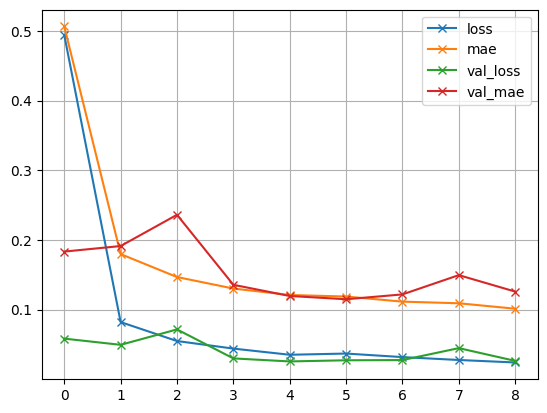

In [84]:
sp = SingleFeaturePipeline(num_days=best_params['num_days'], look_ahead=best_params['look_ahead'])
X_train, X_test, Y_train, Y_test = sp.process(df['btcusd_dClose'])
model = build_model(sp.num_days, ONE_FEATURE, output_size=sp.look_ahead)
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mae'])

epochs = 10
batch = best_params['batch_size']

history = model.fit(X_train,
                    Y_train,
                    validation_data=(X_test, Y_test),
                    epochs=epochs,
                    batch_size=batch,
                    callbacks=[EarlyStopping(patience=4)])

for k,v in history.history.items():
    plt.plot(v, 'x-', label=k)
plt.legend()
plt.grid()

In [93]:
AHEAD = 0
y_hat = sp.restore(model.predict(X_test))
btc_hat = y_hat[:,AHEAD].ravel()
# Y data vector is truncated depending on the num_days, so it is needed to manually offset this
btc_hat = pd.Series(btc_hat, name='prediction', index=df.index[-len(btc_hat)+AHEAD-sp.num_days:AHEAD-sp.num_days])

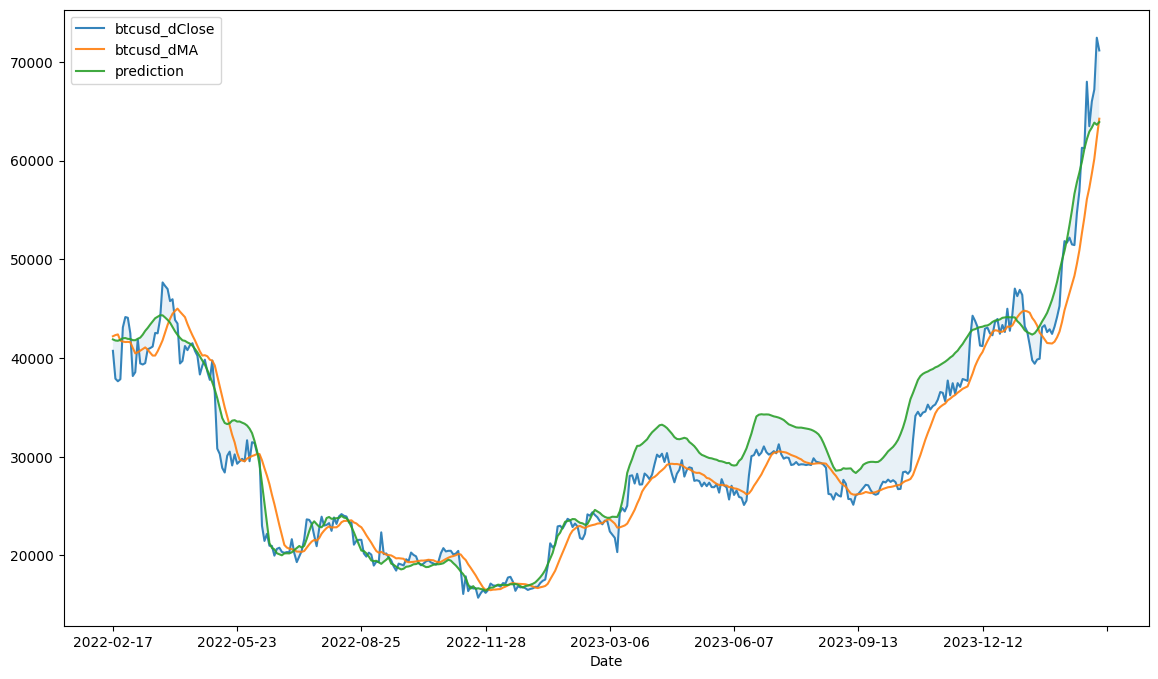

In [90]:
btc = pd.concat([df['btcusd_dClose'], MA['btcusd_dMA'], btc_hat], axis=1).dropna()
btc.plot(figsize=(14,8), style='-', alpha=0.9)
plt.fill_between(btc.index, btc['prediction'], btc['btcusd_dClose'], alpha=0.1)

## Zapis do pliku

In [95]:
import json

model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
with open('params.json', 'w') as json_file:
    json_file.write(json.dumps(best_params))
model.save_weights("model.h5")

# 4. Generalizacja
Ewaluacja modelu na danych indeksu NASDAQ.

> Nie wymaga wcześniejszego wykonania poprzednich etapów pod warunkiem istnienia zapisanego modelu.

In [176]:
from tensorflow.keras.models import model_from_json
import json

with open('model.json', 'r') as json_file:
    loaded_model_json = json_file.read()
with open('params.json', 'r') as json_file:
    loaded_params = json.loads(json_file.read())
model = model_from_json(loaded_model_json)
model.load_weights("model.h5")

In [177]:
from siml_data import Featureset

feature_loader = Featureset()
df = feature_loader.get()

In [178]:
from siml_pipeline import SingleFeaturePipeline
ONE_FEATURE = 1

sp = SingleFeaturePipeline(num_days=loaded_params['num_days'], look_ahead=loaded_params['look_ahead'])
X_train, X_test, Y_train, Y_test = sp.process(df['IXICClose'])

In [179]:
AHEAD = 0
y_hat = sp.restore(model.predict(X_test))
ixic_hat = y_hat[:,AHEAD].ravel()
# Y data vector is truncated depending on the num_days, so it is needed to manually offset this
ixic_hat = pd.Series(ixic_hat, name='prediction', index=df.index[-len(ixic_hat)+AHEAD-sp.num_days:AHEAD-sp.num_days])

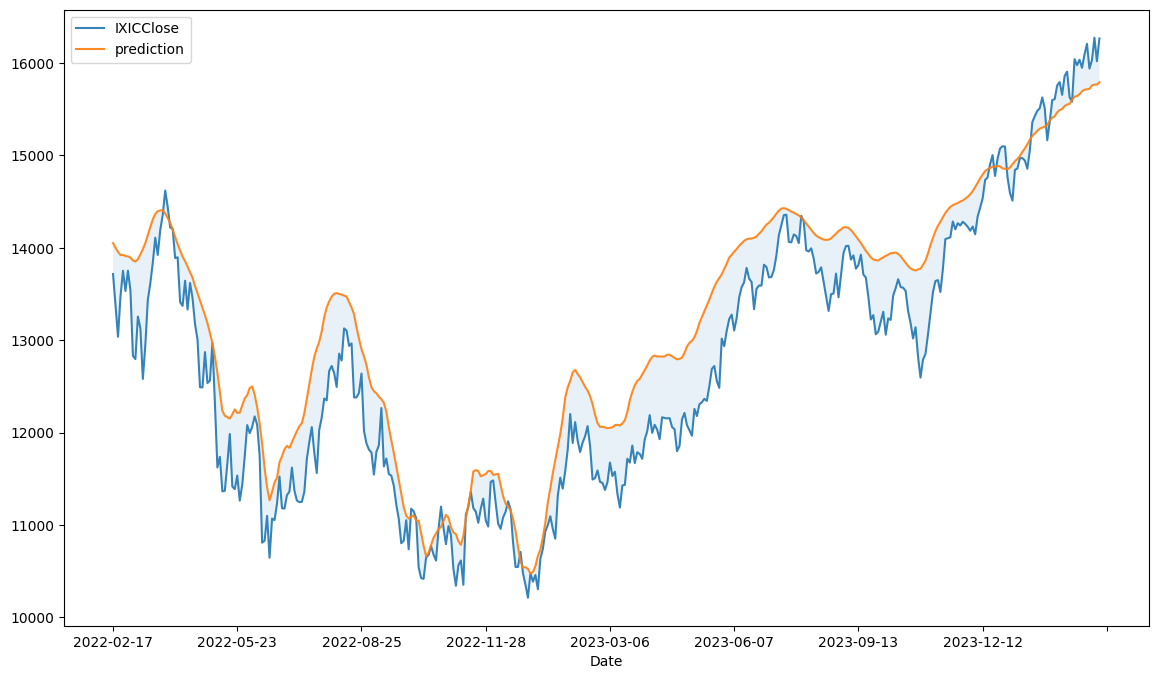

In [180]:
ixic = pd.concat([df['IXICClose'], ixic_hat], axis=1).dropna()
ixic.plot(figsize=(14,8), style='-', alpha=0.9)
plt.fill_between(ixic.index, ixic['prediction'], ixic['IXICClose'], alpha=0.1)

## Dostosowanie modelu do nowych danych

In [181]:
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mae'])

epochs = 2
batch = best_params['batch_size']

history = model.fit(X_train,
                    Y_train,
                    validation_data=(X_test, Y_test),
                    epochs=epochs,
                    batch_size=batch)

Epoch 1/2
79/79 [==============================] - 8s 56ms/step - loss: 0.0209 - mae: 0.1058 - val_loss: 0.0101 - val_mae: 0.0780
Epoch 2/2
79/79 [==============================] - 3s 42ms/step - loss: 0.0162 - mae: 0.0959 - val_loss: 0.0116 - val_mae: 0.0845


In [182]:
AHEAD = 0
y_hat = sp.restore(model.predict(X_test))
ixic_hat = y_hat[:,AHEAD].ravel()
# Y data vector is truncated depending on the num_days, so it is needed to manually offset this
ixic_hat = pd.Series(ixic_hat, name='prediction', index=df.index[-len(ixic_hat)+AHEAD-sp.num_days:AHEAD-sp.num_days])

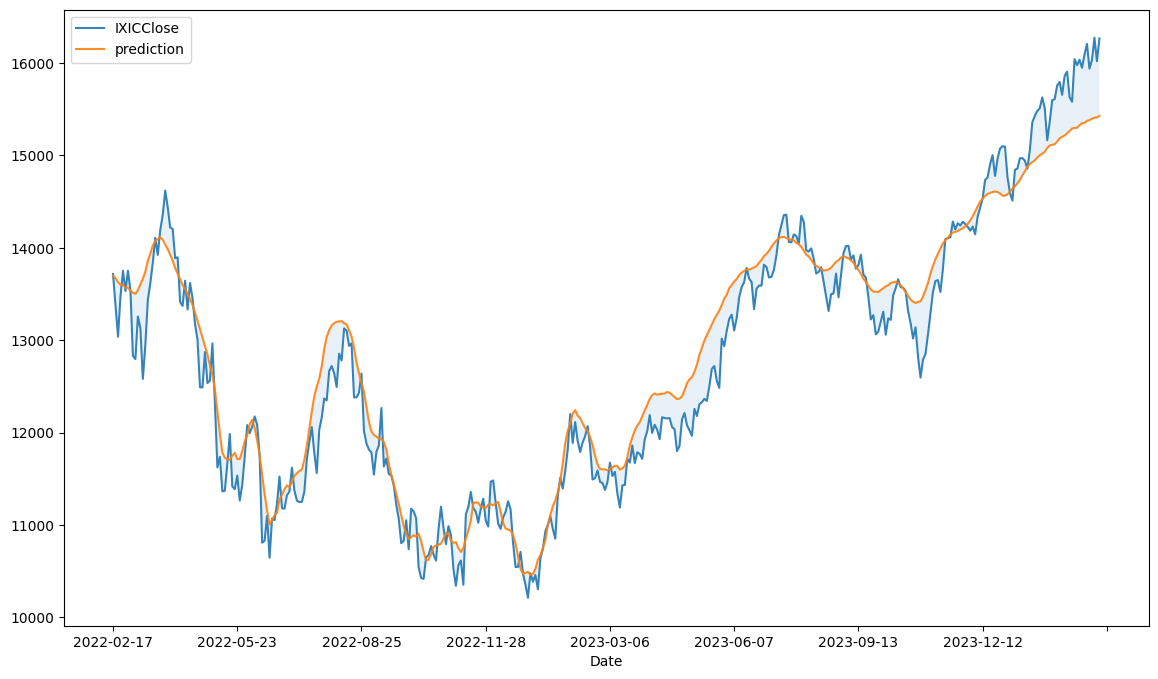

In [183]:
ixic = pd.concat([df['IXICClose'], ixic_hat], axis=1).dropna()
ixic.plot(figsize=(14,8), style='-', alpha=0.9)
plt.fill_between(ixic.index, ixic['prediction'], ixic['IXICClose'], alpha=0.1)